In [49]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [50]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [51]:
from pathlib import Path
from sklearn import metrics

In [52]:
# Sets the video card to be used
torch.cuda.set_device(0)

In [53]:
PATH = Path("data/dog_and_cats_breeds")
list(PATH.iterdir())

[PosixPath('data/dog_and_cats_breeds/.ipynb_checkpoints'),
 PosixPath('data/dog_and_cats_breeds/train.csv'),
 PosixPath('data/dog_and_cats_breeds/test'),
 PosixPath('data/dog_and_cats_breeds/tmp'),
 PosixPath('data/dog_and_cats_breeds/train'),
 PosixPath('data/dog_and_cats_breeds/models')]

In [54]:
labels_csv = PATH/'train.csv'
n = len(list(open(labels_csv)))-1
n

7349

In [55]:
# Creates a random 15% of data for the validation set
val_idxs = get_cv_idxs(n, val_pct=0.15)
len(val_idxs)

1102

In [56]:
labels_df = pd.read_csv(PATH/'train.csv')
labels_df.head()

,id,breed
0,b0234bf14351b079397d8685b2907e8d,keeshond
1,378e20d6c6c2f08fb0d9dce02b22caf4,newfoundland
2,b900795a1441629688fcd8935def1e4e,great_pyrenees
3,a8d369de5c7ef297d19316a19ab24501,great_pyrenees
4,8bff692933224c78840b10d3c1c22a16,leonberger


In [9]:
# Sets the default parameters
sz = 224
arch = resnext101_64
bs = 32

### Inspecting the dataset

In [10]:
breeds_pt = labels_df.pivot_table(index='breed', aggfunc=len)

# Checking how many different breeds
len(breeds_pt)

37

<BarContainer object of 37 artists>

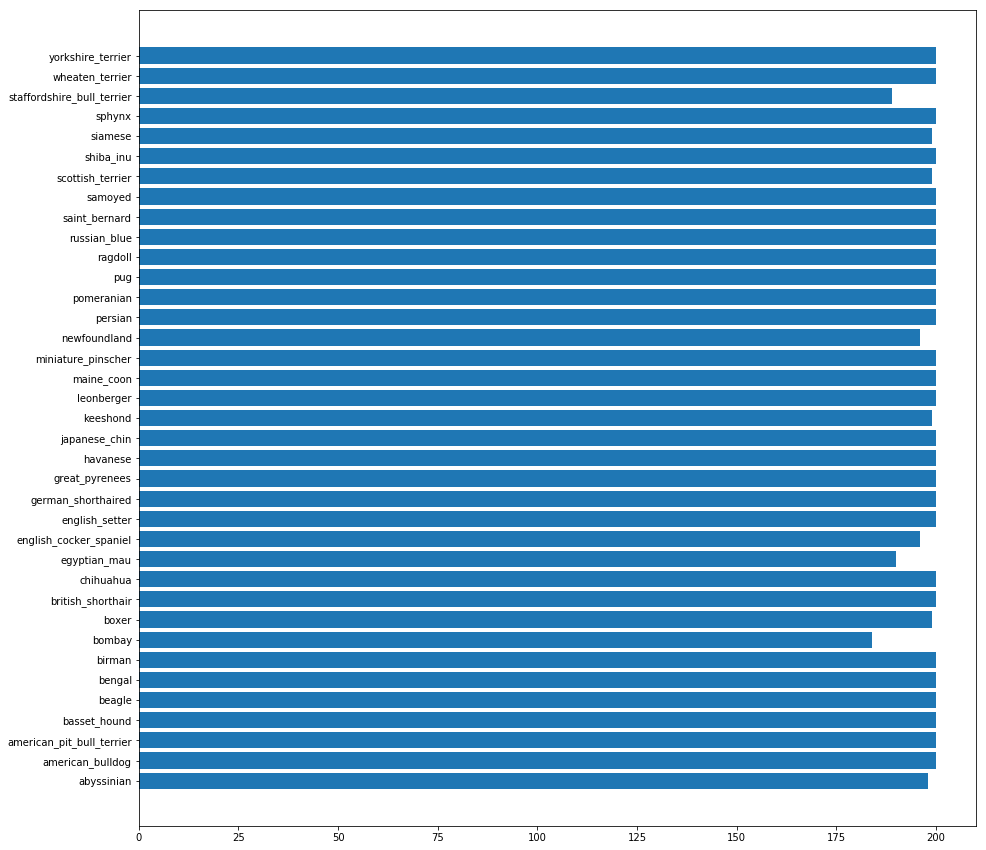

In [11]:
# Checking the distribution of breeds for class balance

fig, ax = plt.subplots(figsize=(15,15))
ax.barh(breeds_pt.index, breeds_pt['id'])

In [12]:
zoom = 1.1

In [13]:
# Sets the augmentations
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=zoom)

In [14]:
data = ImageClassifierData.from_csv(PATH, 'train', labels_csv, test_name='test', 
                                    tfms=tfms, bs=bs, suffix='.jpg', val_idxs=val_idxs, )

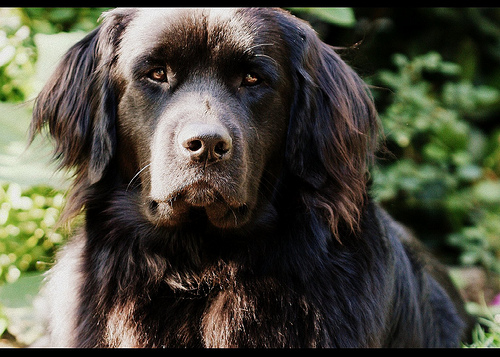

In [15]:
fn = PATH/data.trn_ds.fnames[1]
PIL.Image.open(fn)

In [16]:
len(data.trn_ds), len(data.test_ds), len(data.classes)

(6247, 6849, 37)

### Training the first model

In [17]:
def get_data(sz, bs, idxs):
    tmfs = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=zoom)
    data = ImageClassifierData.from_csv(PATH, 'train', labels_csv, test_name='test',
                                       val_idxs=idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data

In [18]:
data = get_data(sz, bs, val_idxs)

In [19]:
learn = ConvLearner.pretrained(arch, data, ps=0.6, precompute=True)

100%|██████████| 215/215 [01:16<00:00,  2.82it/s]


In [20]:
learn.lr_find()

 74%|███████▍  | 145/196 [00:00<00:00, 228.24it/s, loss=1.77]


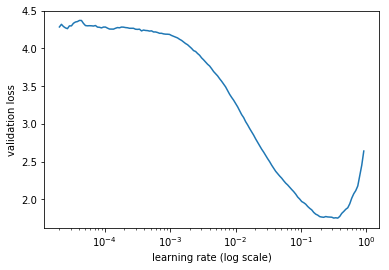

In [21]:
learn.sched.plot()

In [22]:
lr = 1e-2

In [23]:
learn.fit(lr, 8)

epoch      trn_loss   val_loss   accuracy                     
    0      0.536289   0.201612   0.931942  
    1      0.32247    0.161395   0.948276                     
    2      0.264606   0.158695   0.942831                     
    3      0.240706   0.150136   0.948276                     
    4      0.234693   0.130017   0.959165                     
    5      0.201898   0.139463   0.950091                     
    6      0.161987   0.135796   0.954628                     
    7      0.150068   0.130498   0.958258                     



[array([ 0.1305]), 0.95825771292411266]

In [24]:
# Turning precompute off allows data augmentation
learn.precompute = False

In [25]:
learn.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.233085   0.123096   0.96461   
    1      0.214334   0.126698   0.954628                    
    2      0.195001   0.118131   0.96098                     
    3      0.198525   0.122506   0.96098                     
    4      0.17805    0.125208   0.960073                    



[array([ 0.12521]), 0.96007259495678055]

In [26]:
learn.save(f"dog_cats_{sz}")

In [27]:
learn.load(f"dog_cats_{sz}")

### Changing the size of the images to prevent overfitting

In [58]:
learn.set_data(get_data(300, 64, val_idxs))

In [59]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.143468   0.118203   0.95735   
    1      0.127948   0.117935   0.959165                  
    2      0.135051   0.120209   0.96098                   
    3      0.132619   0.12318    0.959165                  
    4      0.124345   0.11418    0.96461                   
    5      0.117155   0.113083   0.96824                   
    6      0.125209   0.114528   0.962795                  



[array([ 0.11453]), 0.96279491800578232]

In [60]:
learn.save(f"dog_cats_{sz}_2")

In [61]:
learn.load(f"dog_cats_{sz}_2")

### Final pass on entire training set

In [32]:
learn.set_data(get_data(300, bs, None))

In [33]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.141066   0.096266   0.969367  
    1      0.150199   0.098167   0.965963                    
    2      0.159937   0.095797   0.970048                    



[array([ 0.0958]), 0.97004765109840585]

In [34]:
learn.save(f"dog_cats_{sz}_3")

In [35]:
learn.load(f"dog_cats_{sz}_3")

### Fine tuning the frozen layers

In [36]:
# Doesn't seem to make an improvement for this dataset
# bs = 8
# learn.set_data(get_data(299, bs, val_idxs))

In [37]:
# learn.unfreeze()

In [38]:
# lr = np.array([1e-4, 1e-3, 1e-2])

In [39]:
# learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

### Performing TTA

In [62]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.96733212341197827, 0.10163589266033599)

### Confusion Matrix

In [63]:
preds = np.argmax(probs, axis=1)
probs = np.exp(log_preds)

In [64]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[33  0  0 ...,  0  0  0]
 [ 0 19  0 ...,  1  0  0]
 [ 0  3 20 ...,  2  0  0]
 ..., 
 [ 0  1  3 ..., 35  0  0]
 [ 0  0  0 ...,  0 29  0]
 [ 0  0  0 ...,  0  0 27]]


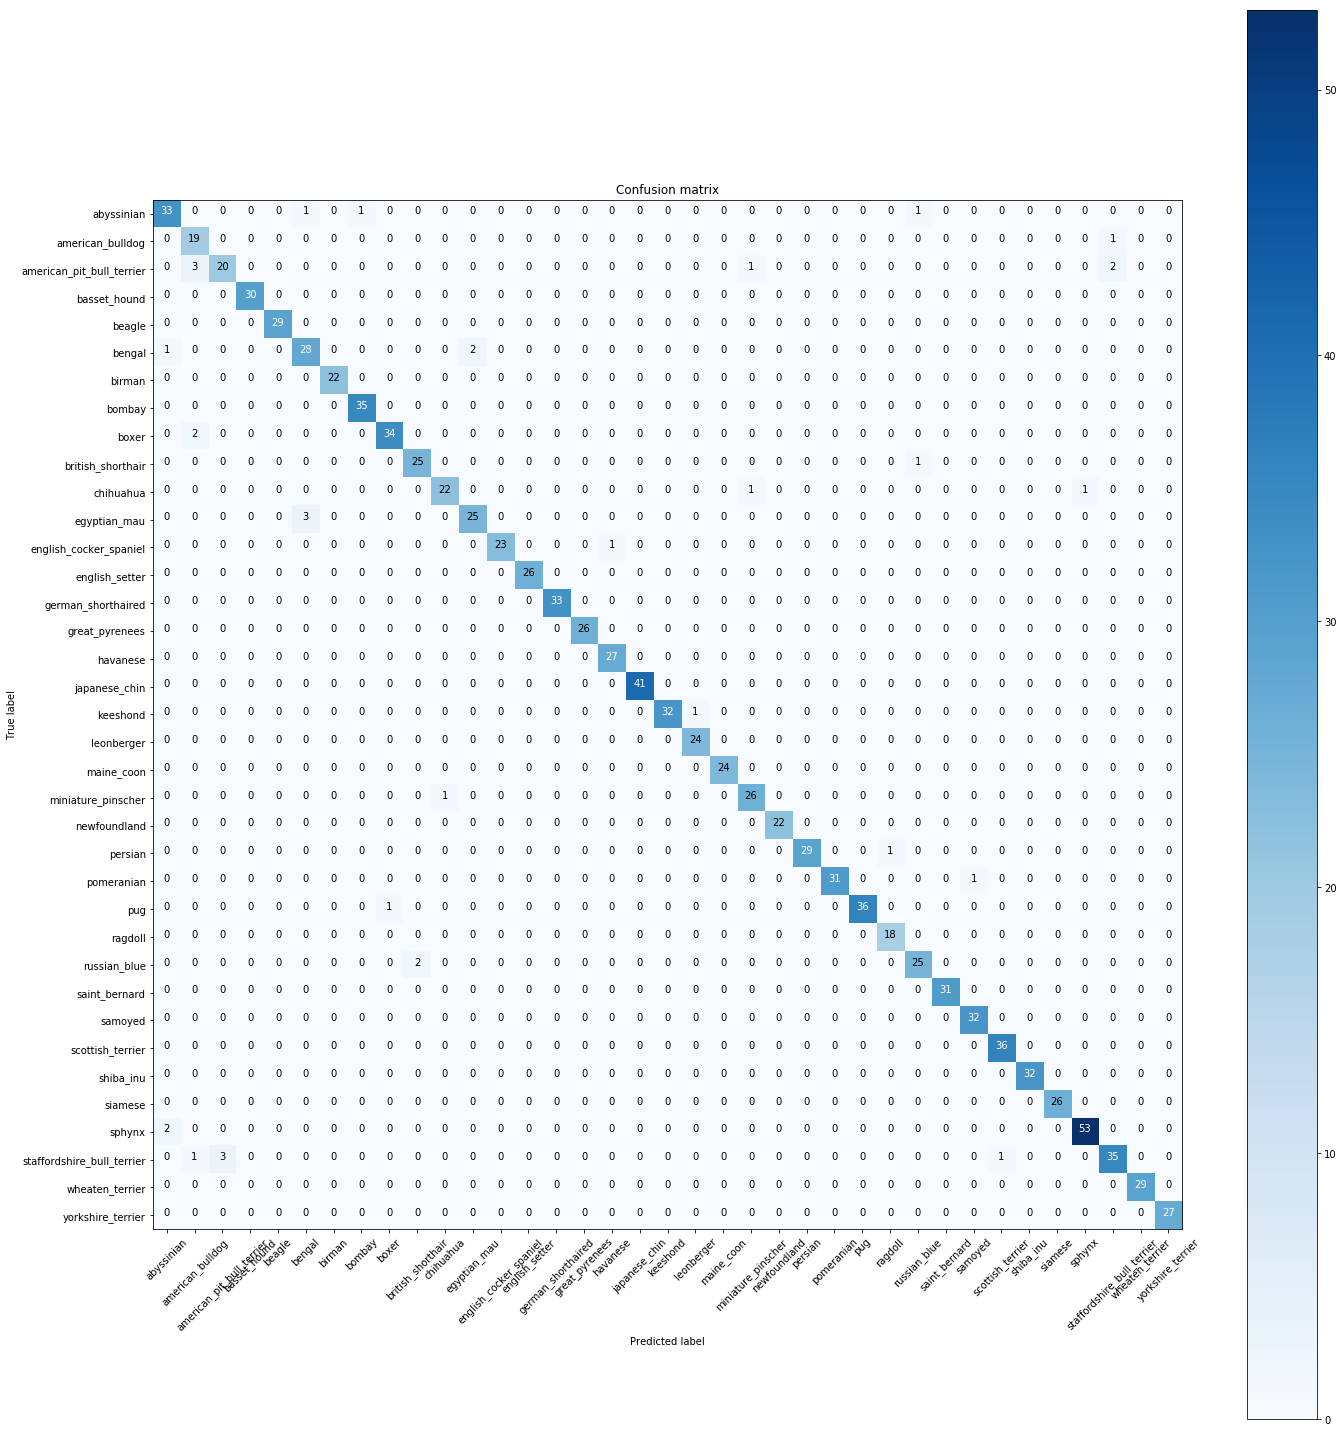

In [65]:
plot_confusion_matrix(cm, data.classes, figsize=(20,20))

### Submission

In [66]:
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), 0)

In [67]:
# Creates the dataframe with the classes as the column names
submit_df = pd.DataFrame(probs)
submit_df.columns = data.classes

In [68]:
# Inserts a column called 'id' of the picutre ids into the first column of the df
fnames = [names[5:-4] for names in data.test_ds.fnames]
submit_df.insert(0, 'id', fnames)

In [69]:
submit_df.head()

,id,abyssinian,american_bulldog,american_pit_bull_terrier,basset_hound,beagle,bengal,birman,bombay,boxer,...,russian_blue,saint_bernard,samoyed,scottish_terrier,shiba_inu,siamese,sphynx,staffordshire_bull_terrier,wheaten_terrier,yorkshire_terrier
0,bd848ac3c41863b4a393914068fdf3f6,6.474470e-08,1.542526e-03,9.768446e-01,1.158888e-06,3.879552e-06,4.594965e-07,1.605124e-07,4.396021e-07,3.234014e-05,...,0.000078,1.331681e-06,6.264769e-07,1.819322e-07,1.790283e-06,1.445751e-07,4.301376e-06,2.138459e-02,2.587838e-06,8.620785e-07
1,a44f09ed06a79d5cf8372e436e27456a,1.854180e-06,8.270991e-09,3.866335e-08,2.342313e-09,9.965514e-08,1.560315e-07,5.186580e-09,9.998587e-01,1.327583e-07,...,0.000078,1.517110e-09,8.916223e-09,4.575492e-07,9.662485e-08,1.878667e-05,4.682076e-07,1.626536e-06,1.988980e-08,8.177581e-09
2,dfdae801a41553251863569ab00dc403,1.090531e-03,1.763000e-06,3.944415e-05,2.524854e-06,2.946109e-06,1.256603e-05,3.465719e-04,2.058255e-01,8.498477e-06,...,0.029281,3.889866e-07,4.614142e-07,1.104092e-06,2.920561e-06,7.603209e-01,9.510587e-06,2.771227e-05,1.812344e-05,1.685939e-06
3,b3cf9bbe10527c7be747bde3c14a548e,8.786720e-03,8.352357e-08,1.738190e-07,1.922070e-07,1.183003e-07,5.617948e-03,3.579762e-08,8.167336e-05,4.682103e-08,...,0.023541,4.337058e-08,3.291044e-07,2.576932e-06,2.676544e-06,2.296430e-06,6.640668e-05,2.555805e-07,7.829756e-07,2.463549e-06
4,8bf3bb9b54053772254e8d3801bc7e61,1.257072e-08,8.312125e-05,9.438478e-01,5.897672e-07,1.409849e-06,9.585042e-08,4.834278e-08,1.497952e-07,1.513049e-06,...,0.000002,9.011152e-08,1.080836e-07,1.277456e-07,3.395483e-07,3.992921e-07,1.045784e-06,5.603428e-02,2.768216e-07,3.328780e-07


In [70]:
submit_df.to_csv('subm', index=False)